### **Definir el directorio de trabajo con Google Colab**
Define el directorio de trabajo como la carpeta `data` de la carpeta compartida `DS4A-Team12` de Drive.

In [1]:
import os
from google.colab import drive 
# Enlazar a la carpeta data de la carpeta compartida en Drive
drive.mount('/content/drive')
working_dir = '/content/drive/MyDrive/DS4A-Team12/data'
os.chdir(working_dir)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/DS4A-Team12/data


In [2]:
# Librerias relevantes 
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm
import os
from scipy import stats, special
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble
%matplotlib inline
plt.style.use('ggplot')

# Opciones de visualización
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Abrir base de datos unidos**
Abre el archivo `Sociodemo_pre.parquet` (5945349 registros, 148 MB) como un dataframe de nombre `soc`, con toda la base de datos, preprocesada para asignarle a cada variable el tipo de dato correspondiente.

Abre también el diccionario del archivo `sociodemo_datatypes_low_memo.json` que permite asignar a las variables tipos de datos para un uso más eficiente de la memoria (641 MB).

In [16]:
def plot_report_accuracy(pscore, outcome, thresholds = [x / 100 for x in range(0, 101)]):
    ''' Takes a 'pscore' series of propensity scores and an 'outcome' series of 1s and 0s.
    Returns as a dictionary: 
        ['optimal_thresholds']: the range of optimal cut off threshold values that maximize 
            accuracy of classification, 
        ['max_accuracy']: the maximum accuracy, and 
        ['plot']: the scatterplot of the accuracy of as a function of the threshold value'''
    accuracy_values = list()
    for threshold in thresholds:
        prediction = (pscore >= threshold)
        accuracy = (prediction == outcome).mean()
        accuracy_values.append(accuracy)
    first_threshold = thresholds[np.argmax(accuracy_values)]
    last_threshold = thresholds[::-1][np.argmax(accuracy_values[::-1])]
    optimal_thresholds = (first_threshold, last_threshold)
    max_accuracy = np.max(accuracy_values)
    plt.rcParams['figure.figsize'] = (6, 4)
    fig = sns.scatterplot(x=thresholds, y=accuracy_values)
    fig.set_xlabel(f'Cutoff values', fontsize=20)
    fig.set_ylabel(f'Accuracy', fontsize=20)
    fig.set_ylim(0, 1)
    fig.set_xlim(-.01, 1.01)
    fig.set_yticklabels([f'{x:.0%}' for x in fig.get_yticks()])
    
    return {'optimal_thresholds' : optimal_thresholds,
            'max_accuracy' : max_accuracy,
            'plot' : fig}

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

In [5]:
import json
# Abre el diccionario con la estructura de datos definida|
soc_datatypes_file = open('datatypes_dictionaries/sociodemo_datatypes_low_memo.json', 'r')
soc_datatypes = json.load(soc_datatypes_file)
# Abre el dataframe
df = pd.read_parquet('preprocessed_data/join_sociodemo_tomas_tagged.parquet')
#df = df.astype(soc_datatypes)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206532 entries, 0 to 1206531
Data columns (total 71 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Cod_clase                  1206532 non-null  int64         
 1   Ind_grupo_sisben_4         1206532 non-null  category      
 2   Ind_nivel_sisben_4         1206532 non-null  int64         
 3   Tip_vivienda               1206532 non-null  int64         
 4   Ind_tiene_energia          1206532 non-null  int64         
 5   Ind_tiene_alcantarillado   1206532 non-null  int64         
 6   Ind_tiene_gas              1206532 non-null  int64         
 7   Ind_tiene_recoleccion      1206532 non-null  int64         
 8   Ind_tiene_acueducto        1206532 non-null  int64         
 9   n_hogares_vivienda         1206532 non-null  UInt8         
 10  Tip_ocupa_vivienda         1206532 non-null  int64         
 11  Ind_tiene_cocina           1206532 no

In [7]:
# Intento de logit
for col in df.columns:
  try: 
    df[col] = df[col].fillna(0)
  except: pass
for col in df.columns[:-2]: #Desde Ind_tiene_energia hasta Estrato
  try:
    df[col] = df[col].astype('float')
  except:
    print(f'{col} not converted to float')
n_reincidencia = df['reincidencia'].sum()

rec = df[df.recuperacion].drop(columns = ['union_temprana', 'Id', 'IdBeneficiario', 'FechaNacimiento',
                                          'Ind_leer_escribir',
                                          'desnutricion', 'recuperacion',
                                          'cod_mpio', 'cod_dpto', 'Tip_vivienda', 'Ind_grupo_sisben_4'])
df_balanced = pd.concat([rec[rec['reincidencia']],
                         rec[~rec['reincidencia']].sample(n=n_reincidencia, random_state=12)])
train_balanced, test = train_test_split(df_balanced, test_size=0.2, random_state=7)


X = train_balanced.drop(columns=['reincidencia'])
y = train_balanced['reincidencia'].astype('int')
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=True, random_state=12)
for data in ['X_train', 'X_test', 'y_train', 'y_test']:
  print(data, globals()[data].shape)

X_train.info()

Ind_grupo_sisben_4 not converted to float
FechaNacimiento not converted to float
X_train (3010, 59)
X_test (1290, 59)
y_train (3010,)
y_test (1290,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3010 entries, 907467 to 586857
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cod_clase                  3010 non-null   float64
 1   Ind_nivel_sisben_4         3010 non-null   float64
 2   Ind_tiene_energia          3010 non-null   float64
 3   Ind_tiene_alcantarillado   3010 non-null   float64
 4   Ind_tiene_gas              3010 non-null   float64
 5   Ind_tiene_recoleccion      3010 non-null   float64
 6   Ind_tiene_acueducto        3010 non-null   float64
 7   n_hogares_vivienda         3010 non-null   float64
 8   Tip_ocupa_vivienda         3010 non-null   float64
 9   Ind_tiene_cocina           3010 non-null   float64
 10  Ind_tiene_nevera           3010 non-null   float64
 11  Ind_

         Current function value: 0.663450
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:           reincidencia   No. Observations:                 3010
Model:                          Logit   Df Residuals:                     2952
Method:                           MLE   Df Model:                           57
Date:                Sat, 04 Sep 2021   Pseudo R-squ.:                 0.04279
Time:                        00:00:34   Log-Likelihood:                -1997.0
converged:                      False   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.867e-14
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Cod_clase                     0.1071      0.081      1.321      0.186      -0.052       0.266
Ind_nivel_sisben_4 

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'max_accuracy': 0.5689922480620155,
 'optimal_thresholds': (0.48, 0.48),
 'plot': <matplotlib.axes._subplots.AxesSubplot at 0x7feb7f04fa90>}

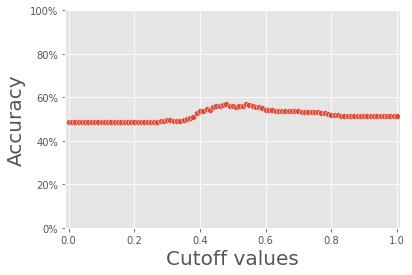

In [17]:
log_todas = sm.Logit(y_train, X_train).fit(maxiter=100)
print(log_todas.summary())
y_pred = log_todas.predict(X_test)
print_score(y_train, round(log_todas.predict(X_train)), train=True)
print_score(y_test, round(y_pred), train=False)
plot_report_accuracy(y_pred, y_test)

In [9]:
pvalues = log_todas.pvalues
cols_significativas = pvalues[pvalues<0.1].reset_index().sort_values(0)
cols_significativas

,index,0
4,Ind_estudia,1.649371e-10
3,Ind_ninguna_discapac,3.292610e-09
6,Tip_hijo,4.408862e-03
1,Ind_tiene_gas,6.295739e-02
7,Edad_padres_menor,7.432496e-02
5,gasto_alim_ppers_imp,8.235138e-02
0,Ind_tiene_alcantarillado,8.259192e-02
2,Sexo,9.301855e-02


In [10]:
cols_importantes=['Ind_ninguna_discapac',
                  'Ind_estudia',
                  'gasto_alim_ppers_imp',
                  'Edad_padres_menor',
                  'ingresos_promP_imp',
                  'Tip_hijo',
                  'Estrato',
                  'Comparte_cocina_sanitario']

Optimization terminated successfully.
         Current function value: 0.676069
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           reincidencia   No. Observations:                 3010
Model:                          Logit   Df Residuals:                     3002
Method:                           MLE   Df Model:                            7
Date:                Sat, 04 Sep 2021   Pseudo R-squ.:                 0.02459
Time:                        00:00:58   Log-Likelihood:                -2035.0
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 3.150e-19
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Ind_ninguna_discapac         -0.8065      0.147     -5.485      0.000      -1.

[]

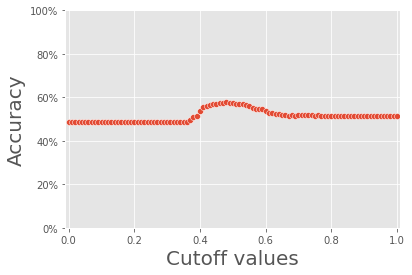

In [18]:
log_imp = sm.Logit(y_train, X_train[cols_importantes]).fit(maxiter=100)
print(log_imp.summary())
y_pred = log_imp.predict(X_test[cols_importantes])
print_score(y_train, round(log_imp.predict(X_train[cols_importantes])), train=True)
print_score(y_test, round(y_pred), train=False)
plot_report_accuracy(y_pred, y_test)['plot'].plot()

Train Result:
Accuracy Score: 88.77%
_______________________________________________
Classification Report:
                     0            1  accuracy    macro avg  weighted avg
precision     0.866117     0.911437  0.887708     0.888777      0.888972
recall        0.914879     0.861001  0.887708     0.887940      0.887708
f1-score      0.889831     0.885501  0.887708     0.887666      0.887647
support    1492.000000  1518.000000  0.887708  3010.000000   3010.000000
_______________________________________________
Confusion Matrix: 
 [[1365  127]
 [ 211 1307]]

Test Result:
Accuracy Score: 59.07%
_______________________________________________
Classification Report:
                    0           1  accuracy    macro avg  weighted avg
precision    0.613559    0.571429  0.590698     0.592494      0.593049
recall       0.546828    0.636943  0.590698     0.591885      0.590698
f1-score     0.578275    0.602410  0.590698     0.590342      0.590024
support    662.000000  628.000000  0.590

{'max_accuracy': 0.5906976744186047,
 'optimal_thresholds': (0.49, 0.5),
 'plot': <matplotlib.axes._subplots.AxesSubplot at 0x7feb1dcd2290>}

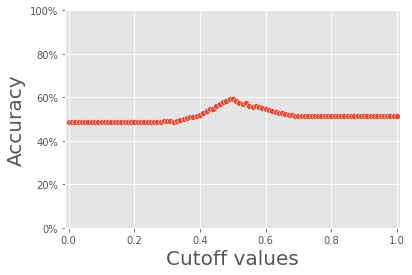

In [19]:
# Intento de random forest
random_forest = ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, random_state=12)
rf_todas = random_forest.fit(X_train, y_train)
y_pred = pd.Series([q  for p, q in rf_todas.predict_proba(X_test)])
# Calculate the threshold that maximizes accuracy
print_score(y_train, rf_todas.predict(X_train), train=True)
print_score(y_test, round(y_pred), train=False)
plot_report_accuracy(y_pred, y_test.reset_index(drop=True))

Train Result:
Accuracy Score: 77.38%
_______________________________________________
Classification Report:
                     0            1  accuracy    macro avg  weighted avg
precision     0.776792     0.770874  0.773754     0.773833      0.773807
recall        0.762735     0.784585  0.773754     0.773660      0.773754
f1-score      0.769699     0.777669  0.773754     0.773684      0.773718
support    1492.000000  1518.000000  0.773754  3010.000000   3010.000000
_______________________________________________
Confusion Matrix: 
 [[1138  354]
 [ 327 1191]]

Test Result:
Accuracy Score: 56.90%
_______________________________________________
Classification Report:
                    0           1  accuracy    macro avg  weighted avg
precision    0.586885    0.552941  0.568992     0.569913      0.570361
recall       0.540785    0.598726  0.568992     0.569756      0.568992
f1-score     0.562893    0.574924  0.568992     0.568908      0.568750
support    662.000000  628.000000  0.568

{'max_accuracy': 0.5790697674418605,
 'optimal_thresholds': (0.53, 0.53),
 'plot': <matplotlib.axes._subplots.AxesSubplot at 0x7feb7f0d1110>}

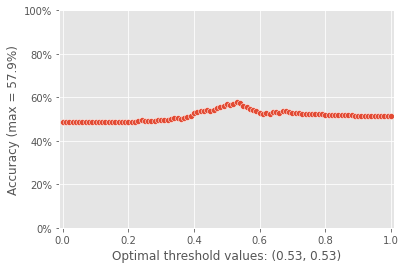

In [13]:
# Intento de random forest
random_forest = ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, random_state=12)
rf_imp = random_forest.fit(X_train[cols_importantes], y_train)
y_pred = pd.Series([q  for p, q in rf_imp.predict_proba(X_test[cols_importantes])])
# Calculate the threshold that maximizes accuracy
print_score(y_train, rf_imp.predict(X_train[cols_importantes]), train=True)
print_score(y_test, round(y_pred), train=False)
plot_report_accuracy(y_pred, y_test.reset_index(drop=True))